# Data Preparation, Logistic Regression and SVM, Model Selection with KFold cross validation

In this notebook we will be looking at data generated by particle physicists to test whether machine learning can help classify whether certain particle decay experiments identify the presence of a Higgs Boson. One does not need to know anything about particle physics to do well here, but if you are curious, full feature and data descriptions can be found here:

- https://www.kaggle.com/c/higgs-boson/data
- http://higgsml.lal.in2p3.fr/files/2014/04/documentation_v1.8.pdf

The goal of this work is to learn sklearn preprocessing on data in the first part and then use that data to build model, predict, calculate metrics and then plot them to compare the accuracies of the model.


### Part 1: Data preparation
Create a data preparation and cleaning function that does the following:
- Has a single input that is a file name string
- Reads data (the data is comma separated, has a row header and the first column `EventID` is the index) into a pandas `dataframe`
- Cleans the data
  - Convert the feature `Label` to numeric (choose the minority class to be equal to 1)
  - If a feature has missing values (i.e., `-999`): 
    - Create a dummy variable for the missing value
      - Call the variable `orig_var_name` + `_mv` where `orig_var_name` is the name of the actual var with a missing value
      - Give this new variable a 1 if the original variable is missing
    - Replace the missing value with the average of the feature (make sure to compute the mean on records where the value isn't missing).
- After the above is done, rescales the data so that each feature has zero mean and unit variance
- Returns the cleaned and rescaled dataset

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, Imputer


def cleanBosonData(infile_name):
    target = 'Label'
    #replace the index_col with the index name in your data set or just ignore it if not in your data
    df = pd.read_csv(infile_name, index_col="EventId")
    #You can also use sklearn's built in encoder or the function in comments
    #Here Label is the target variable
    """
    Counts = df['Label'].value_counts()
    #creat a data frame y where  with 0 the larger number and 1 with minority
    if(Counts['s']>Counts['b']):
        df[target] = df[target].map({'s': 0, 'b': 1})
    else:
        df[target] = df[target].map({'s': 1, 'b': 0})
    
    """
    le = preprocessing.LabelEncoder()
    le.fit(df[target])
    df[target] = le.transform(df[target]) 
    #be sure to convert the target to numeric
    df[target] = pd.to_numeric(df[target], errors='ignore')
    
    #Replace the NAN Values, NAN values can be in any form
    for column in df:
        if -999.0 in df[column].values:
        #create a dummy data and replace -999 with 1 and other with 0
            df[df[column].name+'_mv'] = df[column]
            df[df[column].name+'_mv'] = df[df[column].name+'_mv'].replace(-999.0, 1)
            df[df[column].name+'_mv'] = df[df[column].name+'_mv'].replace(df.loc[df[column] != -999.0][column], 0)
            #now I have a complete dataframe which has all the data, next step is mean replacement
            #you can also use sklearn's imputer for this
            x = df.loc[df[column] != -999.0][column]
            df[column] = df[column].replace(-999.0, x.mean())
    
    #List the name of columns you wish to Scale
    col_names =['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis',
       'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet',
       'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot',
       'DER_mass_MMC_mv', 'DER_deltaeta_jet_jet_mv', 'DER_mass_jet_jet_mv',
       'DER_prodeta_jet_jet_mv']
    
    #Create a copy of dataframe before rescaling, so that you retain Label
    scaled_features = df.copy()
    
    #create a dataframe with only features
    features = scaled_features[col_names]
    
    #Remember to scale only the values and not indices
    scaler = StandardScaler().fit(features.values)
    
    #Transform this back into a dataframe
    features = scaler.transform(features.values)
    
    #Replace the values of these columns in orignal dataframe
    df[col_names] = features
    
    return df

In this part we will build an out-of-the box logistic regression (LR) model and support vector machine (SVM). We will then plot ROC for the LR and SVM model.

Clean the two data files `data/boson_training_cut_2000.csv` and `data/boson_testing_cut.csv`) and use them as training and testing data sets.

In [2]:
#We have already divided Train and Test data in two files. You can do it 
data_train = cleanBosonData("data/boson_training_cut_2000.csv")
data_test = cleanBosonData("data/boson_testing_cut.csv")

In [3]:
#check if the data has been preprocessed properly
data_train.head()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,Label,DER_mass_MMC_mv,DER_deltaeta_jet_jet_mv,DER_mass_jet_jet_mv,DER_prodeta_jet_jet_mv
EventId,,,,,,,,,,,,,,
100000,3.983624e-01,0.092601,0.491173,-0.444021,-1.650125e+00,-1.135322e+00,1.873193,0.888048,1.120050,1,-0.405265,-1.591164,-1.591164,-1.591164
100001,8.633960e-01,0.608117,0.639363,-0.120744,-4.978417e-16,2.786711e-16,0.000000,1.421917,-0.806390,0,-0.405265,0.628471,0.628471,0.628471
100002,-3.235580e-15,3.421843,1.261884,-0.321306,-4.978417e-16,2.786711e-16,0.000000,0.997693,-0.455521,0,2.467519,0.628471,0.628471,0.628471
100003,5.108589e-01,0.989159,0.028516,-0.885926,-4.978417e-16,2.786711e-16,0.000000,1.209152,-0.886831,0,-0.405265,0.628471,0.628471,0.628471
100004,1.172363e+00,-0.953916,1.504447,-0.629578,-4.978417e-16,2.786711e-16,0.000000,1.967534,-0.113790,0,-0.405265,0.628471,0.628471,0.628471


On the training set we build the following models:

- A logistic regression using sklearn's `linear_model.LogisticRegression()`. For this model, use `C=1e30`.
- An SVM using sklearn's `svm.svc()`. For this model, specify that `kernel="linear"`.

For each model above, we also plot the ROC curve of both models on the same plot.
Make sure to use the test set for computing and plotting.

In [4]:
#Lets divide the data beforehand to avoid confusion
#target is the value that you wish to predict, be sure to replace 'Label' with your target variable name
target = 'Label'
X_train = data_train.drop(target,1)
#X_train.head()
Y_train = data_train[target]
#Y_train.head()
X_test = data_test.drop(target,1)
Y_test = data_test[target]

In [5]:
#import statement
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc

In [6]:
def modAUClogReg(X_train, Y_train, X_test, Y_test):
    '''
    trains a linear regression model on train set and returns AUC on test set
    '''
    #Using Scikit-learn the logistic regression model is built with two easy steps.
    clf_LogReg = LogisticRegression(C = 1e30)
    clf_LogReg.fit(X_train, Y_train)
    Y_pred_lg = clf_LogReg.predict_proba(X_test)[:,1]
    fpr_lg, tpr_lg, thresholds_lg = roc_curve(Y_test, Y_pred_lg, drop_intermediate = True)
    return fpr_lg, tpr_lg, thresholds_lg

fpr_lg, tpr_lg, thresholds_lg = modAUClogReg(X_train, Y_train, X_test, Y_test)
roc_auc_lg = auc(fpr_lg, tpr_lg)

In [7]:
#import statements
from sklearn.svm import SVC

In [8]:
def modAUCSVC(X_train, Y_train, X_test, Y_test):
    '''
    trains a SVC on train set and returns AUC on test set
    '''
    clf_SVC = SVC(kernel = "linear", probability = True)
    clf_SVC.fit(X_train, Y_train)
    Y_pred_SVC = clf_SVC.predict_proba(X_test)[:,1]
    fpr_svc, tpr_svc, thresholds_svc = roc_curve(Y_test, Y_pred_SVC)
    roc_auc_svc = auc(fpr_svc, tpr_svc)
    return fpr_svc, tpr_svc, thresholds_svc, roc_auc_svc

fpr_svc, tpr_svc, thresholds_svc, roc_auc_svc = modAUCSVC(X_train, Y_train, X_test, Y_test)


In [9]:
#import staments making our work easier
from matplotlib import pyplot as plt

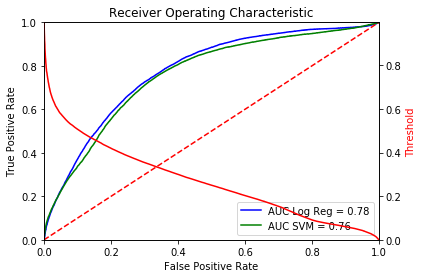

In [10]:
#ploting of the curves
plt.title('Receiver Operating Characteristic')

plt.plot(fpr_lg, tpr_lg, 'b', label = 'AUC Log Reg = %0.2f' % roc_auc_lg)

plt.plot(fpr_svc,tpr_svc,'g',label ='AUC SVM = %0.2f' %roc_auc_svc)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')



ax2 = plt.gca().twinx()
ax2.plot(fpr_lg, thresholds_lg, markeredgecolor='r', color='r')
ax2.set_ylabel('Threshold',color='r')
ax2.set_ylim([thresholds_lg[-1],thresholds_lg[0]])
ax2.set_xlim([fpr_lg[0],fpr_lg[-1]])

plt.show()

Which model performed better?

There is a lot of further scope for experiment. We can use sklearn's scalers, imputers from 4.3 Preprocessing Data module according to our own needs. 

The second part which deals which building a SVC and Logistic regression classifier.

Some refernces:
The best one!!!
http://scikit-learn.org/stable/modules/preprocessing.html#imputation-of-missing-values

A concise theory:

http://www.cs.ccsu.edu/~markov/ccsu_courses/datamining-3.html

Though I have simply used mean to fill in the missing data. It is not always the best practice. A linear regression on the data is best to fill in the missing data. You also need to  be careful that there are no outliers in the data. If there are ouliers, one should just remove those outliers and then take the mean.

Credits: This work is a part of classroom course of Foundations of Data Science under Prof. Rumi Chunara

### Model selection with cross-validation
We think we might be able to improve the performance of the SVM if we perform a grid search on the hyper-parameter $C$.  Because we only have 1000 instances, we will have to use cross-validation to find the optimal $C$.

1\. We write a cross-validation function that does the following:
- Takes as inputs a dataset, a label name, # of splits/folds (`k`), a sequence of values for $C$ (`cs`)
- Performs two loops
  - Outer Loop: `for each f in range(k)`:
    - Splits the data into `data_train` & `data_validate` according to cross-validation logic
  - Inner Loop: `for each c in cs`:
    - Trains an SVM on training split with `C=c, kernel="linear"`
    - Computes AUC_c_k on validation data
    - Stores AUC_c_k in a  dictionary of values
- Returns a dictionary, where each key-value pair is: `c:[auc-c1,auc-c2,..auc-ck]`

In [11]:
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn import linear_model,svm
def xValSVM(dataset, label_name, k, cs):
    
    #initialize a dictionary for storing auc scores
    aucs = dict()
    
    #Get the indices for kfold cross validation
    kf = KFold(n_splits=k, shuffle = True)
    train_indices = list()
    test_indices = list()
    
    #initialize a dictionary to store values with respect to c different values of k
    for c in cs:
        aucs[c] = list()
             
    for train_index, test_index in kf.split(dataset):
        train_indices.append(train_index)
        test_indices.append(test_index)
    #print(test_indices, train_indices)
    
    #perform KFold for different values of c
    for f in range(k):
        
        train_index = list(train_indices[f])
        test_index = list(test_indices[f])
        X_train = dataset.iloc[train_index].drop(target,1)
        Y_train = dataset.iloc[train_index][target]
        
        X_test = dataset.iloc[test_index].drop(target,1)
        Y_test = dataset.iloc[test_index][target]
        
        for c in cs:
            SVMCrss = SVC(C = c , kernel = "linear",probability = True)
            SVMCrss.fit(X_train, Y_train)
            pred = SVMCrss.predict_proba(X_test)[:,1]
            fpr,tpr,threshold = roc_curve(Y_test, pred)
            roc_auc = auc(fpr, tpr)
            aucs[c].append(roc_auc)
        
    return aucs

2\. Using the function written above, do the following:
We generate a sequence of 10 $C$ values in the interval `[10^(-8), ..., 10^1]` (i.e., do all powers of 10 from -8 to 1.
2.	Call aucs = xValSVM(train, ‘Y’, 10, cs)
3.	For each c in cs, get mean(AUC) and StdErr(AUC) 
4.	Compute the value for max(meanAUC-StdErr(AUC)) across all values of c.


In [12]:
C = [10**(-8),10**(-7),10**(-6),10**(-5),10**(-4),10**(-3),10**(-2),10**(-1),10**(0),10]
aucs = xValSVM(data_train,'Label',10, C)
print(aucs)

{1e-08: [0.68831908831908839, 0.71949278438030562, 0.71972656249999989, 0.64713343480466767, 0.65160468080176115, 0.64109890109890111, 0.71370640713706412, 0.72802734374999989, 0.64644693782141183, 0.70903010033444824], 1e-07: [0.68820512820512836, 0.71959889643463493, 0.71983506944444453, 0.64668949771689499, 0.65160468080176115, 0.64098901098901095, 0.71335882284787389, 0.72791883680555547, 0.64644693782141183, 0.70903010033444824], 1e-06: [0.68831908831908839, 0.71912139219015292, 0.71950954861111116, 0.65068493150684936, 0.65172054223149112, 0.64104395604395614, 0.71347468427760397, 0.72819010416666663, 0.64668069191210853, 0.71047937569676711], 1e-05: [0.71076923076923082, 0.70352292020373519, 0.74207899305555558, 0.6981227803145611, 0.65392190939636208, 0.64648351648351654, 0.72471324296141815, 0.7705078125, 0.65568022440392704, 0.73054626532887401], 0.0001: [0.70962962962962961, 0.70309847198641762, 0.74338107638888884, 0.69634703196347036, 0.64824469933958984, 0.650549450549450

In [13]:
stats = dict()
#Intialize a dictionary for storing statistics, though it is not a very good idea when you have a lot of keys
for c in C:
    stats[c] = list()
maximum = 0
for c in C:
    #First value with respect to a key is mean
    stats[c].append(np.mean(aucs[c]))
    #Second value with respect to a key is standard deviation
    stats[c].append(np.std(aucs[c]))
    #Second value with respect to a key is mean - standard deviation
    stats[c].append(stats[c][0]-stats[c][1])
    ##Third value with respect to a key is mean + standard deviation
    stats[c].append(stats[c][0]+stats[c][1])
    #Find the maximum mean - standard deviation
    if(maximum < stats[c][2]):
        maximum = stats[c][2]
        VariableC = c
print("The value of maximum mean - stderror is",maximum )
print("The value of C corresponding to this is", )

The value of maximum mean - stderror is 0.715094481975
The value of C corresponding to this is


### Plot the results 

[-8.0, -7.0, -6.0, -5.0, -4.0, -3.0, -2.0, -1.0, 0.0, 1.0]


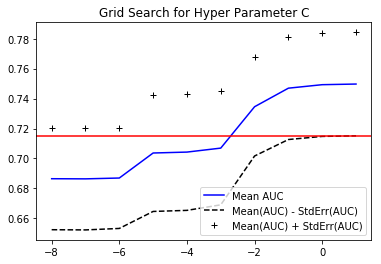

In [14]:
from math import log10
base = [log10(y) for y in C]
print(base)

plt.title("Grid Search for Hyper Parameter C")
plt.plot(base, [stats[c][0] for c in C] , 'b', label = 'Mean AUC' )
plt.plot(base, [stats[c][2] for c in C] , 'k--', label = 'Mean(AUC) - StdErr(AUC)' )
plt.plot(base, [stats[c][3] for c in C], 'k+', label = 'Mean(AUC) + StdErr(AUC)' )
plt.axhline(y=maximum,xmin=base[0], xmax=base[len(base)-1], hold=None, color = 'r')
plt.legend(loc = 'lower right')
plt.show()

### We see that area under curve for SVM increases by 2 % for by changing the hyperparameter 